In [153]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [154]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

print(dataset)
print('------------------')
print('Number of graphs: ', len(dataset))
print('Number of features: ', dataset.num_features)
print('Number of classes: ', dataset.num_classes)

KarateClub()
------------------
Number of graphs:  1
Number of features:  34
Number of classes:  4


In [155]:
print('Graph: ', dataset[0])

Graph:  Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [156]:
print('x = ', dataset[0].x.shape)
print(dataset[0].x)

x =  torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [157]:
print('edge_index = ', dataset[0].edge_index.shape)
print(dataset[0].edge_index)

edge_index =  torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,

In [158]:
from torch_geometric.utils import to_dense_adj

A = to_dense_adj(dataset[0].edge_index)
A

tensor([[[0., 1., 1.,  ..., 1., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 1., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 1.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 1., 1., 0.]]])

In [159]:
print(dataset[0].y)

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


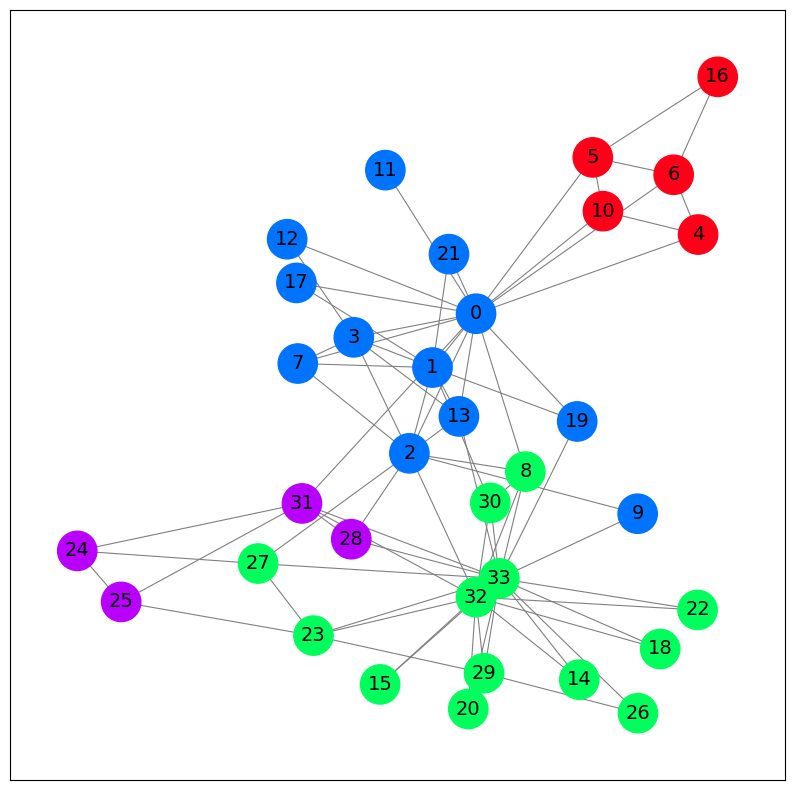

In [160]:
from torch_geometric.utils import to_networkx

G = to_networkx(dataset[0], to_undirected=True)
plt.figure(figsize=(10, 10))
plt.axis = ('off')
nx.draw_networkx(G, 
                 pos=nx.spring_layout(G, seed=0), 
                 with_labels=True,
                 node_size=800,
                 node_color=dataset[0].y,
                 cmap="hsv",
                 vmin=-2,
                 vmax=3,
                 width=0.8,
                 edge_color='gray',
                 font_size=14
)
plt.savefig('karate_club.png')

In [161]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z
    
model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [162]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

embeddings = []
losses = []
accuracies = []
outputs = []

for epoch in range(201):
    optimizer.zero_grad()

    h, z = model(dataset[0].x, dataset[0].edge_index)

    loss = criterion(z, dataset[0].y)

    acc = accuracy(z.argmax(dim=1), dataset[0].y)

    loss.backward()

    optimizer.step()

    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.2f}, Acc: {acc*100:.2f}%')

Epoch: 000, Loss: 1.70, Acc: 11.76%
Epoch: 010, Loss: 1.52, Acc: 11.76%
Epoch: 020, Loss: 1.32, Acc: 35.29%
Epoch: 030, Loss: 1.14, Acc: 35.29%
Epoch: 040, Loss: 0.99, Acc: 38.24%
Epoch: 050, Loss: 0.84, Acc: 67.65%
Epoch: 060, Loss: 0.70, Acc: 82.35%
Epoch: 070, Loss: 0.59, Acc: 88.24%
Epoch: 080, Loss: 0.50, Acc: 88.24%
Epoch: 090, Loss: 0.43, Acc: 88.24%
Epoch: 100, Loss: 0.37, Acc: 88.24%
Epoch: 110, Loss: 0.32, Acc: 88.24%
Epoch: 120, Loss: 0.28, Acc: 97.06%
Epoch: 130, Loss: 0.25, Acc: 97.06%
Epoch: 140, Loss: 0.22, Acc: 97.06%
Epoch: 150, Loss: 0.20, Acc: 100.00%
Epoch: 160, Loss: 0.18, Acc: 100.00%
Epoch: 170, Loss: 0.17, Acc: 100.00%
Epoch: 180, Loss: 0.15, Acc: 100.00%
Epoch: 190, Loss: 0.14, Acc: 100.00%
Epoch: 200, Loss: 0.13, Acc: 100.00%


In [163]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    G = to_networkx(dataset[0], to_undirected=True)
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, seed=42),
                     with_labels=True,
                     node_size=800,
                     node_color=outputs[i],
                     cmap="hsv",
                     vmin=-2,
                     vmax=3,
                     width=0.8,
                     edge_color='gray',
                     font_size=14
    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%', fontsize=18, pad=20)

fig = plt.figure(figsize=(10, 10))
plt.axis=('off')

anim = animation.FuncAnimation(fig, animate, np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())

In [164]:
display(html)

In [165]:
print(f'Final embedding shape: {h.shape}')
print(h)

Final embedding shape: torch.Size([34, 3])
tensor([[1.6081e+00, 3.3672e+00, 7.2409e-01],
        [2.1105e+00, 2.3943e+00, 1.3389e+00],
        [1.5914e+00, 1.3180e+00, 9.9747e-01],
        [1.8754e+00, 2.2070e+00, 9.6554e-01],
        [0.0000e+00, 2.5754e+00, 6.5541e-04],
        [0.0000e+00, 2.8099e+00, 0.0000e+00],
        [0.0000e+00, 2.6670e+00, 0.0000e+00],
        [1.5515e+00, 1.7387e+00, 9.3946e-01],
        [1.1278e+00, 2.5055e-01, 1.4521e+00],
        [1.2402e+00, 1.2094e+00, 7.4721e-01],
        [0.0000e+00, 2.4431e+00, 0.0000e+00],
        [1.4662e+00, 1.7975e+00, 9.2811e-01],
        [1.5554e+00, 1.8503e+00, 8.2506e-01],
        [1.4248e+00, 1.4964e+00, 9.3670e-01],
        [8.4318e-01, 1.4722e-04, 1.3705e+00],
        [8.0017e-01, 0.0000e+00, 1.4115e+00],
        [0.0000e+00, 2.5126e+00, 0.0000e+00],
        [1.6000e+00, 1.7635e+00, 9.1294e-01],
        [8.2662e-01, 0.0000e+00, 1.3720e+00],
        [1.4391e+00, 1.5095e+00, 1.0149e+00],
        [7.9887e-01, 1.8084e-04, 1.38

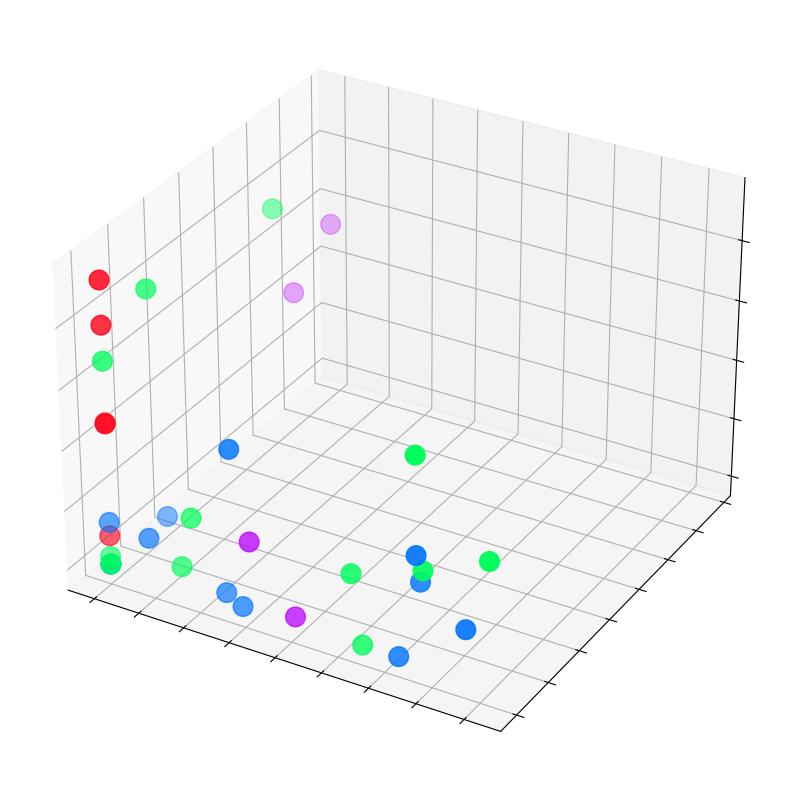

In [166]:
embed = embeddings[0].detach().cpu().numpy()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(
    left=False,
    bottom=False,
    labelleft=False,
    labelbottom=False
)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2], s=200, c=dataset[0].y, cmap="hsv", vmin=-2, vmax=3)
plt.savefig('karate_club_embedding.png')

In [167]:
%%capture

def animate_embed(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2], s=200, c=dataset[0].y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%', fontsize=18, pad=40)

fig = plt.figure(figsize=(10, 10))
plt.axis = ('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

anim = animation.FuncAnimation(fig, animate_embed, np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())

In [168]:
display(html)